#### Import Library

#### def function

In [3]:
import pandas as pd
import numpy as np
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
  prevs, items, nexts = tee(some_iterable, 3)
  prevs = chain([None], prevs)
  nexts = chain(islice(nexts, 1, None), [None])
  return zip(prevs, items, nexts)

def labeling(produksi:list[int|float]|np.ndarray):
  min, max = produksi.min(), produksi.max()
  range_data = (max - min)/3
  label = []

  for x in produksi:
    if x < min+range_data:
      label.append('S')
    elif min+range_data <= x < min+range_data*2:
      label.append('C')
    elif x > min+range_data*2:
      label.append('B')

  return np.array(label)

def probabilitas_awal(label:np.ndarray):
  unique_val, count = np.unique(label,return_counts=True)
  count = [round(x/count.sum(),4) for x in count]
  return np.flip(unique_val), np.flip(count)

def matrix_transisi(label:np.ndarray):
  transisi = np.zeros((3,3))

  for _, item, nxt in previous_and_next(label):
    if nxt is None :
      continue
    ps = ['S','C','B'].index(item)
    pd = ['S','C','B'].index(nxt)
    transisi[ps][pd] += 1

  for i,y in enumerate(transisi):
    row_total = y.sum()
    for j,x in enumerate(y):
      transisi[i][j] = round(x/row_total,4)

  return transisi

def find_steady_state(prob_awal:np.ndarray,transisi:np.ndarray,max_iteration:int=100):
  new_prob = [round(x,4) for x in np.matmul(prob_awal,transisi)]
  prev_val,streak,i = new_prob,0,0
  while i < max_iteration:
    new_prob = [round(x,4) for x in np.matmul(new_prob,transisi)]
    if np.all(np.equal(prev_val,new_prob)):
      streak += 1
    else:
      streak = 0

    if streak > 3:
      return True, new_prob
    
    prev_val = new_prob
    i += 1

  return False, None

In [4]:
df = pd.read_excel("DataKubisKur.xlsx")
label = labeling(df.values[:,1])
labelproba, proba = probabilitas_awal(label)
mtransisi = matrix_transisi(label)
_, SteadyState = find_steady_state(proba,mtransisi)

In [24]:
df.tail()

,Tahun,Jumlah Panen
19,2019,50453.0
20,2020,56136.0
21,2021,59868.0
22,2022,9999.0
23,2023,213123.0


In [93]:
import networkx as nx
color = ["red", "green", "blue"]
G = nx.Graph()
G.add_nodes_from(labelproba)

In [94]:
label = ["S", "C", "B"]
for row, row_data in enumerate(mtransisi):
  for col, cell_data in enumerate(row_data):
    if cell_data > 0:
      state = (label[row],label[col])
      G.add_edge(*state, weight=cell_data)

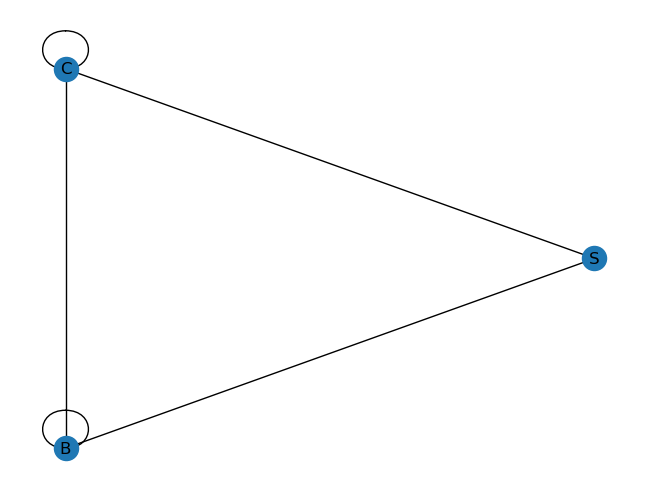

In [103]:
nx.draw(G, nx.circular_layout(G), with_labels=True)

{('S', 'C'): Text(63.103, 80.17099999999999, '0.1667'),
 ('S', 'B'): Text(45.296, 48.967, '0.0769'),
 ('C', 'C'): Text(99.206, 80.408, '0.5'),
 ('C', 'B'): Text(81.399, 49.204, '0.0769'),
 ('B', 'B'): Text(63.592, 18.0, '0.8462')}

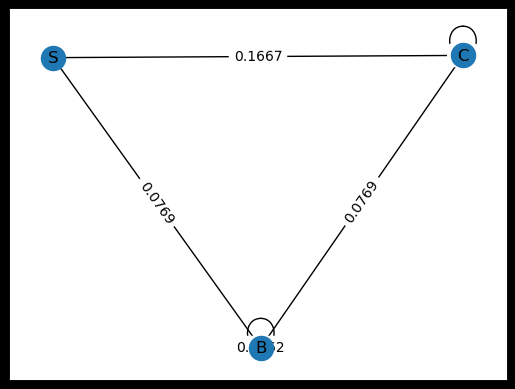

In [95]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.set_facecolor("white")
labels = nx.get_edge_attributes(G,'weight')
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

#### GUI

In [2]:
import tkinter as tk
import customtkinter as ctk
import pandas as pd
import numpy as np
from itertools import tee, islice, chain

class App(ctk.CTk):
  def __init__(self):
    super().__init__()
    self.title("Markov Chain")
    self.steady_state = None
    self.has_steady_state = lambda:self.steady_state is not None
    self.window_width = 800 
    self.window_height = 600
    self.grid_rowconfigure(0, weight=1)
    self.grid_columnconfigure(0, weight=1)
    self._init_component()
    self._center_window()

  def _init_component(self):
    self.menu_frame = ctk.CTkFrame(self,corner_radius=0)
    self.menu_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

    self.open_button = ctk.CTkButton(self.menu_frame, text="Open", command=self._open_file, corner_radius=0)
    self.open_button.pack(anchor="center",side=tk.LEFT,expand=True, padx=10, pady=10)

    self.add_button = ctk.CTkButton(self.menu_frame, text="Tambah", command=self._add_data, corner_radius=0)
    self.add_button.pack(anchor="center",side=tk.LEFT,expand=True, padx=10, pady=10)

    self.credit_button = ctk.CTkButton(self.menu_frame, text="Credits", command=self._show_credits, corner_radius=0)
    self.credit_button.pack(anchor="center",side=tk.LEFT,expand=True, padx=10, pady=10)

    self.tab_view = ctk.CTkTabview(self, corner_radius=0)
    self.tab_view.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=10, pady=(0,10))
    self.tab_view.add("Data")
    self.tab_view.add("Prediksi")
    self._init_prediksi()

  def _center_window(self):
    screen_width = self.winfo_screenwidth()
    screen_height = self.winfo_screenheight()
    x = (screen_width - self.window_width) // 2
    y = (screen_height - self.window_height) // 2

    self.geometry(f"{self.window_width}x{self.window_height}+{x}+{y}")

  def _clear_data(self):
    for widget in self.tab_view.tab("Data").winfo_children():
       widget.destroy()
    self.frame_table.pack_forget()
    self.frame_markov.pack_forget()

  def _init_prediksi(self):
    self.frame_prediksi = ctk.CTkFrame(self.tab_view.tab("Prediksi"), corner_radius=0)
    self.frame_prediksi.pack(side=tk.TOP, fill=tk.BOTH, padx=10, pady=10)
    self.input_prediksi = ctk.CTkEntry(self.frame_prediksi, placeholder_text="insert year", corner_radius=0)
    self.input_prediksi.pack(side=tk.LEFT,fill=tk.BOTH,expand=True, padx=10, pady=5)
    self.button_prediksi = ctk.CTkButton(self.frame_prediksi, text="predict", command=self._prediksi, corner_radius=0)
    self.button_prediksi.pack(side=tk.LEFT,fill=tk.BOTH, padx=10, pady=5)
    pass

  def _init_table(self):
    if self.data is not None:
      ### Data
      self.frame_table = ctk.CTkScrollableFrame(self.tab_view.tab("Data"), corner_radius=0)
      self.frame_table.pack(side=tk.LEFT, anchor=tk.W, fill=tk.BOTH, padx=10, pady=10)
      
      for i, header in enumerate(self.data.columns):
        label = ctk.CTkLabel(self.frame_table, text=header, fg_color="transparent")
        label.grid(row=0, column=i, sticky=tk.NSEW, padx=8, pady=2)
      
      for row, row_data in enumerate(self.data.values, start=1):
        for column, cell_data in enumerate(row_data):
          label = ctk.CTkLabel(self.frame_table, text=int(cell_data) if column == 0 else cell_data)
          label.grid(row=row, column=column, sticky=tk.NSEW)
      
      ### Prob A & Matrik Transisi
      self.frame_markov = ctk.CTkFrame(self.tab_view.tab("Data"), corner_radius=0)
      self.frame_markov.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)

      self.ctklabel_proba = ctk.CTkLabel(self.frame_markov, text="Probabilitas Awal")
      self.ctklabel_proba.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      self.frame_proba = ctk.CTkFrame(self.frame_markov, corner_radius=0)
      self.frame_proba.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      for row, row_data in enumerate([self.label_proba, self.proba]):
        for column, cell_data in enumerate(row_data):
          label = ctk.CTkLabel(self.frame_proba, text=cell_data)
          label.grid(row=row, column=column, sticky="ew", padx=20)

      self.ctklabel_matrixtrans = ctk.CTkLabel(self.frame_markov, text="Matrix Transisi")
      self.ctklabel_matrixtrans.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      self.frame_matrixtrans = ctk.CTkFrame(self.frame_markov, corner_radius=0)
      self.frame_matrixtrans.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      for i, header in enumerate([" ",*self.label_proba]):
        label = ctk.CTkLabel(self.frame_matrixtrans, text=header, fg_color="transparent")
        label.grid(row=0, column=i, sticky=tk.NSEW, padx=8, pady=2)
      for row, row_data in enumerate(np.c_[self.label_proba, self.m_transisi], start=1):
        for column, cell_data in enumerate(row_data):
          label = ctk.CTkLabel(self.frame_matrixtrans, text=cell_data)
          label.grid(row=row, column=column, sticky="ew", padx=20)

      ### Steady State
      self.ctklabel_steadystate = ctk.CTkLabel(self.frame_markov, text="Steady State")
      self.ctklabel_steadystate.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      self.frame_steadystate = ctk.CTkFrame(self.frame_markov, corner_radius=0)
      self.frame_steadystate.pack(side=tk.TOP, anchor=tk.CENTER, fill=tk.BOTH, padx=10, pady=10)
      if not self.has_steady_state():
        ss_404 = ctk.CTkLabel(self.frame_steadystate, text="Steady State Not Found")
        ss_404.grid(row=0, column=0, sticky="ew", padx=20)
      else:
        for column, cell_data in enumerate(self.steady_state):
          label = ctk.CTkLabel(self.frame_steadystate, text=str(cell_data))
          label.grid(row=0, column=column, sticky="ew", padx=20)
        
    
  def _new_file(self):
    pass

  def _open_file(self):
    filetypes = [("Excel Files", "*.xlsx"), ("CSV Files", "*.csv")]
    filepath = tk.filedialog.askopenfilename(title="Open File", filetypes=filetypes)
    if filepath:
      if filepath.endswith(".xlsx"):
        self.data = pd.read_excel(filepath)
      elif filepath.endswith(".csv"):
        self.data = pd.read_csv(filepath)
      self.tahun = self.data.values[:,0]
      self.produksi = self.data.values[:,1]
      self._labeling()
      self._probabilitas_awal()
      self._matrix_transisi()
      self._find_steady_state()
      if len(self.tab_view.tab("Data").winfo_children()) > 0:
        self._clear_data()
      self._init_table()

  def _prediksi(self):
    input = self.input_prediksi.get()
    print(input)

  def _add_data(self):
    tahun = ctk.CTkInputDialog(text="Data Tahun (angka):", title="Input Data Tahun")
    produksi = ctk.CTkInputDialog(text="Data Produksi (angka):", title="Input Data Produksi")
    print(tahun, produksi)
    pass

  def _show_credits(self):
    tk.messagebox.showinfo("Credits", "Developer")

  def __previous_and_next(self,some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

  def _labeling(self):
    produksi = self.produksi
    min, max = produksi.min(), produksi.max()
    range_data = (max - min)/3
    label = []

    for x in produksi:
      if x < min+range_data:
        label.append('S')
      elif min+range_data <= x < min+range_data*2:
        label.append('C')
      elif x > min+range_data*2:
        label.append('B')

    self.label = np.array(label)
    self.data['label'] = self.label
    return self.label

  def _probabilitas_awal(self):
    unique_val, count = np.unique(self.label,return_counts=True)
    count = [round(x/count.sum(),4) for x in count]
    self.label_proba = np.flip(unique_val)
    self.proba = np.flip(count)
    return self.label_proba, self.proba

  def _matrix_transisi(self):
    transisi = np.zeros((3,3))

    for _, item, nxt in self.__previous_and_next(self.label):
      if nxt is None :
        continue
      ps = ['S','C','B'].index(item)
      pd = ['S','C','B'].index(nxt)
      transisi[ps][pd] += 1

    for i,y in enumerate(transisi):
      row_total = y.sum()
      for j,x in enumerate(y):
        transisi[i][j] = round(x/row_total,4)

    self.m_transisi = transisi
    return self.m_transisi

  def _find_steady_state(self,max_iteration:int=100):
    new_prob = [round(x,4) for x in np.matmul(self.proba,self.m_transisi)]
    prev_val,streak,i = new_prob,0,0
    while i < max_iteration:
      new_prob = [round(x,4) for x in np.matmul(new_prob,self.m_transisi)]
      if np.all(np.equal(prev_val,new_prob)):
        streak += 1
      else:
        streak = 0

      if streak > 3:
        self.steady_state = new_prob
        return True, new_prob
      
      prev_val = new_prob
      i += 1

    self.steady_state = None
    return False, None

# Create the main window
app = App()
app.mainloop()

invalid command name "139627780180608check_dpi_scaling"
    while executing
"139627780180608check_dpi_scaling"
    ("after" script)
invalid command name "139627780187200update"
    while executing
"139627780187200update"
    ("after" script)
